# Titanic Survival Predictions

## The problem

The sinking of the Titanic resulted in the death of 1502 out of 2224 passengers and crew.
Apparently there were some patterns in the people who died and the people who survived.
The problem here is that I have certain data with specific characteristics of each passenger and the data is already labeled which lets me know if the passenger lived or died. 
I have been given also another dataset with more Titanic passengers and their characteristics but this dataset is not labeled, so I don't know who lived and who died.
To be able to predict which passengers were more likely to survive I will use a couple of algorithms to train the first dataset and when I decide which one is the best I will use it to predict what passengers in the unlabeled dataset survived.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from math import sqrt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
%matplotlib inline

Author = "Daniela Alvarez"
Email = "daniela.alvarez04@gmail.com"

In [2]:
# In case I use the XGBClassifier

import sys
!{sys.executable} -m pip install xgboost

## Loading the data

In [3]:
#load the data into a Pandas dataframe

def load_file(file):
    return pd.read_csv(file)

In [4]:
print("Loading data")

train_df = load_file('data/train.csv')
test_df = load_file('data/test.csv')

Loading data


In [5]:
print("The first 5 rows of the dataframe")
train_df.head()

The first 5 rows of the dataframe


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Cleaning the data

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train_df.duplicated().sum()

0

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [9]:
test_df.duplicated().sum()

0

In [10]:
train_df.describe(include = "all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Andersson, Miss. Erna Alexandra",male,NaN,NaN,NaN,1601,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Exploratory Data Analysis

(0.0, 1.05)

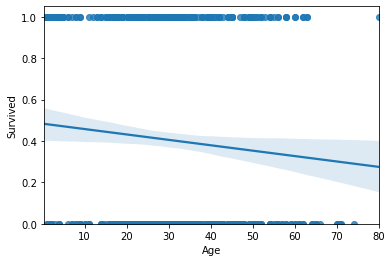

In [11]:
#View if there is a linear relation between continuous numerical variable Age & target variable Survived.
sns.regplot(x = "Age", y = "Survived", data = train_df)
plt.ylim(0,)

Yes, there is a negative linear relation between Age and Survived feature, which means that the older you were, the less probability to survive you had.

(0.0, 2.1133957618792163)

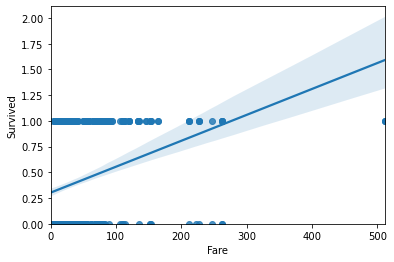

In [12]:
#View if there is a linear relation between continuous numerical variable Fare & target variable Survived.
sns.regplot(x = "Fare", y = "Survived", data = train_df)
plt.ylim(0,)

Yes, there is a positive linear realtion between Fare and Survived feature which means that people who paid a more expensive fare had more probabilities to survive.

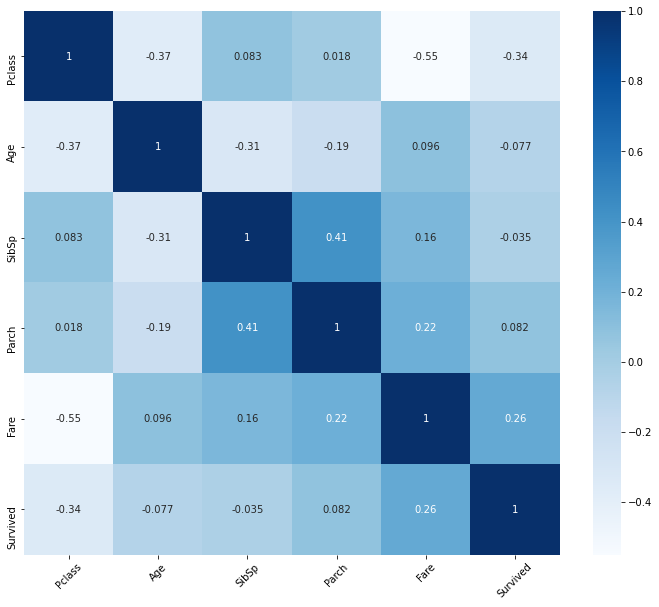

In [13]:
#Look for correlation between each feature and the target
#Look for correlation between features
#PassengerId is discarded for having unique values.

fig = plt.figure(figsize=(12,10))
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
sns.heatmap(train_df[features + ['Survived']].corr(), cmap = 'Blues', annot=True)
plt.xticks(rotation = 45)
plt.savefig('images/heatmap.png')
plt.show()


There is a strong correlation between Parch(how many parents or children) and Sibsp (how many siblings and spouses) did passengers had in the Titanic.
Comparing to the target feature "Survived" this plot confirms that there is a positive correlation between Fare and Survived, because the more expensive the fare you paid, the more likely you survived; and this is also correlated to the PClass feature which has a negative strong correlation with Survived feature. This makes a lot of sense because PClass 1 (passenger class 1) should have had the most expensive fare, and PClass 3 must have been the class with the cheapest fare.

In [14]:
#Delete irrelevant variables like name, passenger id and ticket number. Delete Cabin because it has a 77% of missing values 
#from both train and test datasets.

train_df = train_df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis= 1)
test_df = test_df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis= 1)

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [16]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


After deleting the columns I consider not relevant, I verified my train and test datasets to see which type of values are the missing values.
I see that I will have to impute the Age feature in both datasets, and I will use the mean age of the training set to replace the age missing values in train and test dataset.
The same happens with the "Fare" feature in the test set but in this case I can not touch the test set yet, so I will use the mean Fare in the training set to impute that 1 missing value in the test set.

There is another feature "Embarked" in the training set which has 2 missing values, so here I will impute it with the most frequent value of that feature.

I will transform my training set as if my test set does not exist, and before making the predictions I will make the same transformations to my test set. 

In [17]:
def replace_with_avg(df, col):
    average = df[col].mean(axis=0)
    print("The average is:" , average)
    df[col].replace(np.nan, average , inplace = True)
    print("Replacing missing values with average:", average)    

In [18]:
def replace_with_frequent(df,col):
    frequent = df[col].value_counts().idxmax()
    print("The most frequent value is:", frequent)
    df[col].replace(np.nan, frequent , inplace = True)
    print("Replacing missing values with the most frequent value:", frequent)

In [19]:
#As there are missing values in "Age" feature in the training set I will use directly my function.
replace_with_avg(train_df, "Age")

The average is: 29.69911764705882
Replacing missing values with average: 29.69911764705882


In [20]:
#As there are 2 values missing in "Embarked" feature, I will use the most frequent value in that feature.
replace_with_frequent(train_df, "Embarked")

The most frequent value is: S
Replacing missing values with the most frequent value: S


In [21]:
categories_df = train_df.copy()
categories_df = train_df.select_dtypes(include=['object'])
encoded_df = categories_df.copy()

In [22]:
encoded_df = pd.get_dummies(encoded_df)
train_df = train_df.drop(["Sex", "Embarked"], axis = 1)

In [23]:
train = pd.concat([train_df, encoded_df], axis = 1)
train_target = train["Survived"]
train_features = train.drop(["Survived"], axis = 1)

## Selecting the best algorithm

In [24]:
# Knearest neighbor model, but first scaling features.

clf = KNeighborsClassifier(n_neighbors = 5)
scaler = StandardScaler()

In [25]:
pipeline = Pipeline([("transformer", scaler), ("estimator", clf)])

In [26]:
#Divide the train set in 5 folds to cross validate.
skf = StratifiedKFold(n_splits=5)

In [27]:
#Generate 5 scores as it tests 5 different times
scores = cross_val_score(pipeline, train_features, train_target, cv = skf)
print("Accuracy of the algorithm for each fold:", scores)

Accuracy of the algorithm for each fold: [0.7877095  0.78089888 0.8258427  0.80898876 0.8258427 ]


In [28]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()

In [29]:
skf_rf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [30]:
scores_rf = cross_val_score(clf_rf, train_features, train_target, cv = skf_rf)
print("Accuracy of the algorithm for each subset:", scores_rf)

Accuracy of the algorithm for each subset: [0.83240223 0.80337079 0.79775281 0.8258427  0.83707865]


## Training

Based on the results now I use the Random Forest algorithm to train my entire training set.

In [31]:
clf_rf.fit(train_features, train_target)

RandomForestClassifier()

Let´s see which were the most important features

In [32]:
print(clf_rf.feature_importances_)

[0.08511798 0.26087214 0.04871459 0.03900147 0.25063568 0.14661432
 0.13573578 0.01223233 0.00633178 0.01474395]


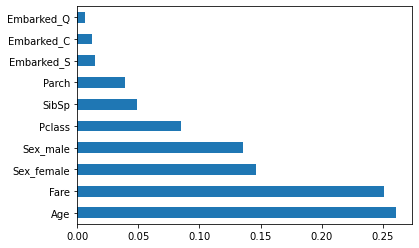

In [33]:
feat_importances = pd.Series(clf_rf.feature_importances_, index=train_features.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.savefig('images/feature_importances.png')
plt.show()

## Ready to make the same transformations to my test set and use my built model to predict survival.

In [34]:
#As there are missing values in "Age" feature in the test set I will use the age average in training set and 
#impute the test set.

age_average = train_df['Age'].mean(axis=0)
print("The average is:" , age_average)

test_df['Age'].replace(np.nan, age_average , inplace = True)
print("Replacing missing values in test dataset with average:", age_average)

The average is: 29.69911764705882
Replacing missing values in test dataset with average: 29.69911764705882


In [35]:
#As there are missing values in "Fare" feature in the test set I will use the fare average in training set and 
#impute the test set.

fare_average = train_df['Fare'].mean(axis=0)
print("The average is:" , fare_average)

test_df['Fare'].replace(np.nan, fare_average , inplace = True)
print("Replacing missing values in test dataset with average:", fare_average)

The average is: 32.204207968574636
Replacing missing values in test dataset with average: 32.204207968574636


In [36]:
categories_test_df = test_df.copy()
categories_test_df = test_df.select_dtypes(include=['object'])
encoded_test_df = categories_test_df.copy()

In [37]:
encoded_test_df = pd.get_dummies(encoded_test_df)
test_df = test_df.drop(["Sex", "Embarked"], axis = 1)

In [38]:
test = pd.concat([test_df, encoded_test_df], axis = 1)

In [39]:
predictions = clf_rf.predict(test)

Let's save the model, predictions and feature importances.

In [40]:
#Save the model to disk.

import pickle

filename = "final_model.sav"

pickle.dump(clf_rf, open(filename, 'wb'))

In [41]:
#Save predictions to csv.
np.savetxt('predictions.csv', predictions, delimiter=',')

In [42]:
#Save feature importances to csv.
feat_importances.to_csv('feature_importances.csv') 

### Some time in future to load model from disk

In [43]:
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)